In [1]:
!pip install --upgrade pip
!pip install -q efficientnet

In [2]:
import numpy as np 
import pandas as pd

import time
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, ResNet50V2, VGG16, VGG19
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print(tf.__version__)

2.4.1


In [4]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


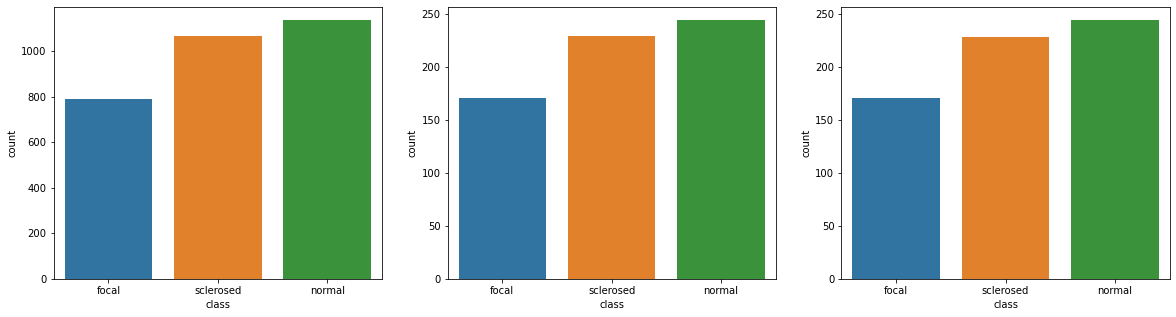

In [6]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [7]:
BUFFER_SIZE = len(train_folders)

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
IMG_SIZE = 150

In [8]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [9]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_folders,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=BUFFER_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_SIZE, IMG_SIZE))

validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                              shuffle=BUFFER_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              class_mode='categorical', 
                                                              target_size=(IMG_SIZE, IMG_SIZE))

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.


In [10]:
test_datagen = ImageDataGenerator( rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
test_generator = test_datagen.flow_from_directory(test_folders,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=BUFFER_SIZE,
                                                   class_mode='categorical',
                                                   target_size=(IMG_SIZE, IMG_SIZE))

Found 643 images belonging to 3 classes.


In [11]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'focal': 0, 'normal': 1, 'sclerosed': 2}
{0: 'focal', 1: 'normal', 2: 'sclerosed'}


In [12]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


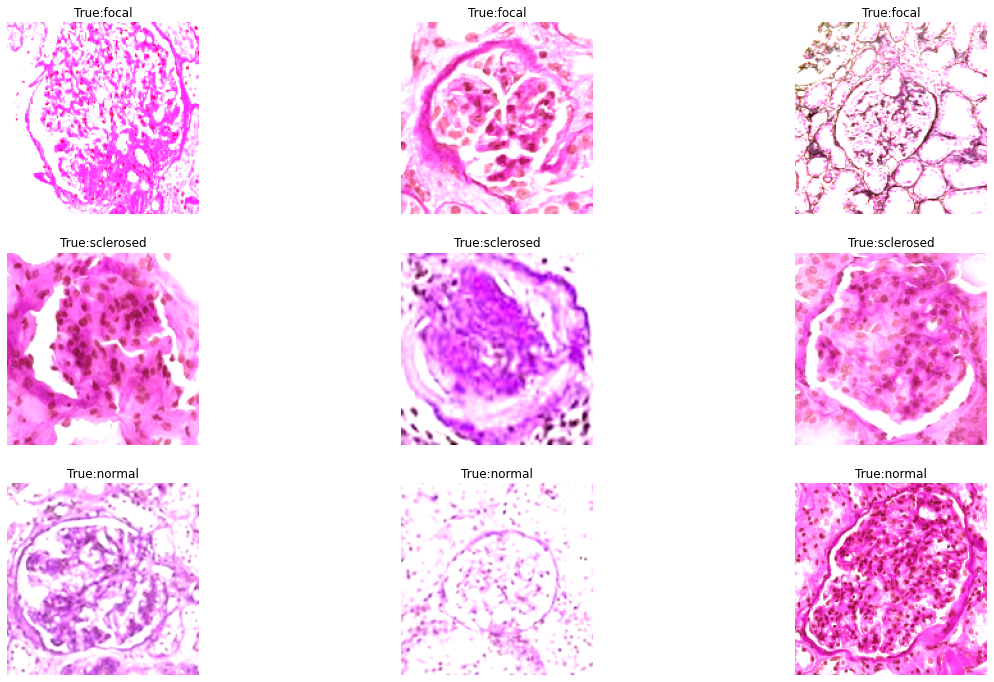

In [13]:
show_few_images(3,None)

In [14]:
#tf.keras.backend.clear_session()

# epoch config
EPOCH = 60

## VGG16

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        

47/47 [==============================] - 11s 226ms/step - loss: 0.0619 - acc: 0.9858 - val_loss: 0.2409 - val_acc: 0.9190

Epoch 00057: val_acc did not improve from 0.92056
Epoch 58/60
47/47 [==============================] - 10s 220ms/step - loss: 0.0621 - acc: 0.9840 - val_loss: 0.2745 - val_acc: 0.8988

Epoch 00058: val_acc did not improve from 0.92056
Epoch 59/60
47/47 [==============================] - 11s 226ms/step - loss: 0.0545 - acc: 0.9850 - val_loss: 0.2562 - val_acc: 0.9128

Epoch 00059: val_acc did not improve from 0.92056
Epoch 60/60
47/47 [==============================] - 10s 221ms/step - loss: 0.0540 - acc: 0.9891 - val_loss: 0.2698 - val_acc: 0.9097

Epoch 00060: val_acc did not improve from 0.92056
Training completed in 11m 48s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


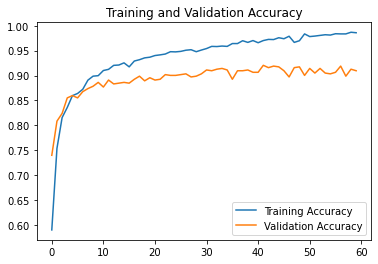

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


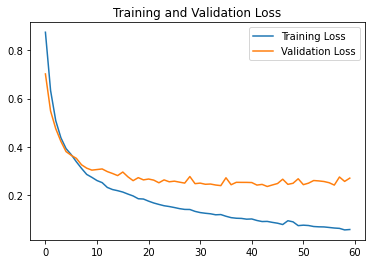

<Figure size 432x288 with 0 Axes>

In [15]:
with strategy.scope():
    vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in vgg16_model.layers:
                layers.trainable=False
    last_output = vgg16_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(128, activation = 'relu')(vgg_x)
    vgg_x = Dense(3, activation = 'softmax')(vgg_x)
    vgg16_final_model = Model(vgg16_model.input, vgg_x)
    vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

vgg16_final_model.summary()
since = time.time()
vgg16_history = vgg16_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg16_history, 'vgg16_model')

In [16]:
vgg16_final_model.evaluate(test_generator)
vgg16_best_model = vgg16_final_model

11/11 [==============================] - 12s 1s/step - loss: 0.2883 - acc: 0.9036


## VGG19

In [ ]:
with strategy.scope():
    vgg19_model = VGG19(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in vgg19_model.layers:
                layers.trainable=False
    last_output = vgg19_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(128, activation = 'relu')(vgg_x)
    vgg_x = Dense(3, activation = 'softmax')(vgg_x)
    vgg19_final_model = Model(vgg19_model.input, vgg_x)
    vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG19
vgg19_filepath = 'vgg_19_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg19_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

vgg19_final_model.summary()
since = time.time()
vgg19_history = vgg19_final_model.fit(train_generator, epochs = EPOCH ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg19_history, 'vgg19_model')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

47/47 [==============================] - 10s 224ms/step - loss: 0.2201 - acc: 0.9182 - val_loss: 0.2877 - val_acc: 0.8972

Epoch 00020: val_acc did not improve from 0.89875
Epoch 21/60
47/47 [==============================] - 11s 224ms/step - loss: 0.2174 - acc: 0.9153 - val_loss: 0.2803 - val_acc: 0.8941

Epoch 00021: val_acc did not improve from 0.89875
Epoch 22/60
47/47 [==============================] - 11s 224ms/step - loss: 0.2001 - acc: 0.9342 - val_loss: 0.2723 - val_acc: 0.8910

Epoch 00022: val_acc did not improve from 0.89875
Epoch 23/60
47/47 [==============================] - 10s 221ms/step - loss: 0.1994 - acc: 0.9313 - val_loss: 0.2682 - val_acc: 0.8956

Epoch 00023: val_acc did not improve from 0.89875
Epoch 24/60
47/47 [==============================] - 11s 223ms/step - loss: 0.2037 - acc: 0.9287 - val_loss: 0.2641 - val_acc: 0.8972

Epoch 00024: val_acc did not improve from 0.89875
Epoch 25/60
47/47 [==============================] - 11s 225ms/step - loss: 0.1822 - ac

In [ ]:
vgg19_final_model.evaluate(test_generator)
vgg19_best_model = vgg19_final_model

## ResNet50

In [ ]:
with strategy.scope():
    ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet50_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet50_x = Flatten()(ResNet50_model.output)
    resnet50_x = Dense(256,activation='relu')(resnet50_x)
    resnet50_x = Dense(3,activation='softmax')(resnet50_x)
    resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
    resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]

resnet50_x_final_model.summary()
since = time.time()
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet50_history, 'resnet50_model')

In [ ]:
resnet50_x_final_model.evaluate(test_generator)
resnet50_best_model = resnet50_x_final_model

## ResNet50V2

In [ ]:
with strategy.scope():
    ResNet50v2_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    #for layers in ResNet5v2_model.layers:
    #    layers.trainable=False

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet50v2_x = Flatten()(ResNet50v2_model.output)
    resnet50v2_x = Dense(256,activation='relu')(resnet50v2_x)
    resnet50v2_x = Dense(3,activation='softmax')(resnet50v2_x)
    resnet50v2_x_final_model = Model(inputs=ResNet50v2_model.input, outputs=resnet50v2_x)
    resnet50v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_filepath = 'resnet50v2'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]

resnet50v2_x_final_model.summary()
since = time.time()
resnet50v2_history = resnet50v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet50v2_history, 'resnet50v2_model')

In [ ]:
resnet50v2_x_final_model.evaluate(test_generator)
resnet50v2_best_model = resnet50v2_x_final_model

## EfficientNetB7

In [ ]:
with strategy.scope():
    effb7_model = EfficientNetB7(pooling='avg', 
                        weights='imagenet', 
                        include_top=False, 
                        input_shape=(150,150,3))
    for layers in effb7_model.layers:
                layers.trainable=False

    last_layer = effb7_model.get_layer('avg_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    effb7_x = Flatten()(last_output)
    effb7_x = Dense(1024, activation = 'relu')(effb7_x)
    effb7_x = Dropout(0.2)(effb7_x)
    effb7_x = Dense(3, activation = 'softmax')(effb7_x)
    effb7_final_model = Model(effb7_model.input, effb7_x)
    effb7_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

# EFFB7
effb7_final_model.summary()

effb7_filepath = 'effb7-'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(effb7_filepath, monitor='val_acc', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=1, verbose=1, mode='min', epsilon=0.0001, min_lr=0)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min', restore_best_weights=True)
callbacks_list = [checkpoint, reduce_lr, es]

since = time.time()
effb7_history = effb7_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effb7_history, 'effb7_model')

In [ ]:
effb7_final_model.evaluate(test_generator)
effb7_best_model = effb7_final_model

## EfficientNetL2

In [ ]:
path_weight = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/efficientnet/noisy-student/notop/efficientnet-l2_noisy-student_notop.h5'
with strategy.scope():
    effl2_model = EfficientNetL2(pooling='avg', 
                                 weights=path_weight, 
                                 include_top=False, 
                                 input_shape=(IMG_SIZE,IMG_SIZE,3),
                                 drop_connect_rate=0)
    for layers in effl2_model.layers:
                layers.trainable=False

    last_layer = effl2_model.get_layer('avg_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    effl2_x = Flatten()(last_output)
    effl2_x = Dense(1024, activation = 'relu')(effl2_x)
    effl2_x = Dropout(0.2)(effl2_x)
    effl2_x = Dense(3, activation = 'softmax')(effl2_x)
    effl2_final_model = Model(effl2_model.input, effl2_x)
    effl2_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

# EFFL2
effl2_final_model.summary()

effl2_filepath = 'effl2-'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(effl2_filepath, monitor='val_acc', verbose=1, save_best_only=True)
callbacks_list = [checkpoint, reduce_lr, es]

since = time.time()
effl2_history = effl2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effl2_history, 'effl2_model')

In [ ]:
effl2_final_model.evaluate(test_generator)
effl2_best_model = effl2_final_model

## Combining Similar Model 

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_vgg_pred = []
combined_resnet_pred = []
combined_effnet_pred = []
vgg16_pred = []
resnet50_pred = []
effnetb7_pred = []
vgg19_pred = []
resnet50v2_pred = []
effnetl2_pred = []
for folder in os.listdir(val_folders):
    
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        
        path = os.path.join(val_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
        img_normalized = img/IMG_SIZE
        
        #vgg16
        vgg16_image_prediction = np.argmax(vgg16_best_model.predict(np.array([img_normalized])))
        vgg16_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet50_image_prediction = np.argmax(resnet50_best_model.predict(np.array([img_normalized])))
        resnet50_pred.append(resnet50_image_prediction)
        
        #effnetb7
        effnetb7_image_prediction = np.argmax(effb7_best_model.predict(np.array([img_normalized])))
        effnetb7_pred.append(effnetb7_image_prediction)
        
        #vgg19
        vgg19_image_prediction = np.argmax(vgg19_best_model.predict(np.array([img_normalized])))
        vgg19_pred.append(vgg19_image_prediction)
        
        #resnet50v2
        resnet50v2_image_prediction = np.argmax(resnet50v2_best_model.predict(np.array([img_normalized])))
        resnet50v2_pred.append(resnet50v2_image_prediction)
        
        #effnetl2
        effnetl2_image_prediction = np.argmax(effl2_best_model.predict(np.array([img_normalized])))
        effnetl2_pred.append(effnetl2_image_prediction)
        
        #combine_vgg
        image_prediction = mode([vgg19_image_prediction, vgg16_image_prediction])                                  
        combined_vgg_pred.append(image_prediction)
        
        #combine_resnet
        image_prediction = mode([resnet50v2_image_prediction, resnet50_image_prediction])                                  
        combined_resnet_pred.append(image_prediction)
        
        #combine_efficientnet
        image_prediction = mode([effnetb7_image_prediction, effnetl2_image_prediction])                                  
        combined_effnet_pred.append(image_prediction)

## Define Classification

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

## Result of Classification

In [ ]:
#combined vgg
combined_vgg_pred = [ c[0] for c in combined_vgg_pred]
clf_report(true_value, combined_vgg_pred)

In [ ]:
#combined resnet
combined_resnet_pred = [ c[0] for c in combined_resnet_pred]
clf_report(true_value, combined_resnet_pred)

In [ ]:
#combined effnet
combined_effnet_pred = [ c[0] for c in combined_effnet_pred]
clf_report(true_value, combined_effnet_pred)

In [ ]:
# VGG16 model classification report
clf_report(true_value, vgg16_pred)

In [ ]:
# VGG19 model classification report
clf_report(true_value, vgg19_pred)

In [ ]:
# Resnet50 model classification report
clf_report(true_value, resnet50_pred)

In [ ]:
# Resnet50v2 model classification report
clf_report(true_value, resnet50v2_pred)

In [ ]:
# EfficientNetB7 model classification report
clf_report(true_value, effnetb7_pred)

In [ ]:
# EfficientNetL2 model classification report
clf_report(true_value, effnetl2_pred)

## Display Prediction Images

In [ ]:
show_few_images(1,vgg16_best_model)

In [ ]:
show_few_images(1,vgg19_best_model)

In [ ]:
show_few_images(1,resnet50_best_model)

In [ ]:
show_few_images(1,resnet50v2_best_model)

In [ ]:
show_few_images(1,effb7_best_model)

In [ ]:
show_few_images(1,effl2_best_model)